In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

device = torch.device('cuda:0')

In [2]:
class PUBG_imglike_dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        def transfrom2imglike(input):
            output = np.zeros((3,32,32))
            temp = np.array(input)
            for x in range(23):
                for y in range(23):
                    if(x == y):
                        output[0][x][y] = temp[x]
                        output[1][x][y] = temp[x]
                        output[2][x][y] = temp[x]
            return output
        # get one line in csv
        player_id = self.frame.iloc [idx, 0]
        player_stats = self.frame.iloc [idx, [x for x in range(3, 27) if x != 15]].values.astype(np.int_)
        player_stats = torch.tensor(transfrom2imglike(player_stats))
        win_place_perc = torch.tensor(self.frame.iloc [idx, 28])
        if self.transform:
            player_stats = self.transform(player_stats)
        sample = {
            "player_id": player_id, 
            "player_stats": player_stats,
            "win_place_perc": win_place_perc
        }
        return sample
    

        

In [3]:
def get_dataset(csv_file, train_dataset_size_ratio, batch_size):
    dataset = PUBG_imglike_dataset(csv_file)
    #  `torch.utils.data.random_split` meets server problem and lead to CRASH
    # see also:
    # - a denied fix PR for this problem: https://github.com/pytorch/pytorch/pull/9237 
    #train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor((1-train_dataset_size_ratio) * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
    print("load dataset: train dataset: {}, test dataset: {}.".format(len(train_loader)*batch_size, len(test_loader)*batch_size))
    return (train_loader, test_loader)

In [4]:
# load dataset
csv_file = 'train_small.csv'
train_dataset_size_ratio = 0.9
batch_size = 128
train_loader, test_loader = get_dataset(csv_file, train_dataset_size_ratio, batch_size)

load dataset: train dataset: 1152, test dataset: 128.


In [5]:
class MyCNN(nn.Module):
    
    def __init__(self, image_size, num_classes):
        super(MyCNN, self).__init__()
        # conv1: Conv2d -> BN -> ReLU -> MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # conv2: Conv2d -> BN -> ReLU -> MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # fully connected layer
        self.fc = nn.Linear(32 * (image_size // 4) * (image_size // 4), num_classes)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # view(x.size(0), -1): change tensor size from (N ,H , W) to (N, H*W)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output

In [6]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [7]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    # train the model using minibatch
    for i, data in enumerate(train_loader):
        stats, prec = data['player_stats'], data['win_place_perc']
        stats, prec = stats.to(torch.float32).to(device), prec.to(device)

        # forward
        outputs = model(stats)
        loss = loss_func(outputs, prec)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        #if (i + 1) % 10 == 0:
        #    print ("Step [{}/{}] Train Loss: {:.4f}".format(i+1, len(train_loader), loss.item()))
    #print ("Train Loss: {:.4f}".format(loss.item()))
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):

    model.eval()
    with torch.no_grad():
        loss = 0
        total = 0
        
        for i, data in enumerate(val_loader):
            stats, prec = data['player_stats'], data['win_place_perc']
            stats, prec = stats.to(torch.float32).to(device), prec.to(device)

            outputs = model(stats)

            
            loss += (torch.abs(torch.t(outputs) - prec)).sum()
            total += prec.size(0)

            
        accuracy = loss / total
        #print('Test Loss: {:.4f}'.format(accuracy))
        return accuracy
    
def fit(model, num_epochs, optimizer, device):
    loss_func = nn.MSELoss()
    model.to(device)
    if device == torch.device('cuda'):
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True
    loss_func.to(device)
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        

        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
        # print loss
        if (epoch+1) % 10 == 0:
            print("Epoch {}/{}".format(epoch+1, num_epochs))
            print("Train Loss: {:.4f}".format(loss))
            print('Test Loss: {:.4f}'.format(accuracy))

    show_curve(losses, "train loss")
    show_curve(accs, "test loss")

In [12]:
# training setting
# hyper parameters
num_epochs = 100
lr = 0.01
image_size = 32
num_classes = 1

# declare and define an objet of MyCNN
mycnn = MyCNN(image_size, num_classes)
print(mycnn)
# Device configuration, cpu, cuda:0/1/2/3 available
device = torch.device('cuda:0')

optimizer = torch.optim.Adam(mycnn.parameters(), lr=lr)



MyCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


Epoch 10/100
Train Loss: 0.0935
Test Loss: 0.2885
Epoch 20/100
Train Loss: 0.0891
Test Loss: 0.2799
Epoch 30/100
Train Loss: 0.0936
Test Loss: 0.2773
Epoch 40/100
Train Loss: 0.0976
Test Loss: 0.2735
Epoch 50/100
Train Loss: 0.0938
Test Loss: 0.2802
Epoch 60/100
Train Loss: 0.0926
Test Loss: 0.2720
Epoch 70/100
Train Loss: 0.0945
Test Loss: 0.2770
Epoch 80/100
Train Loss: 0.0945
Test Loss: 0.2765
Epoch 90/100
Train Loss: 0.0936
Test Loss: 0.2753
Epoch 100/100
Train Loss: 0.0952
Test Loss: 0.2762


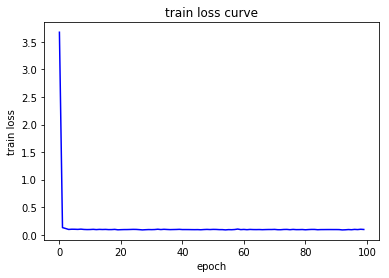

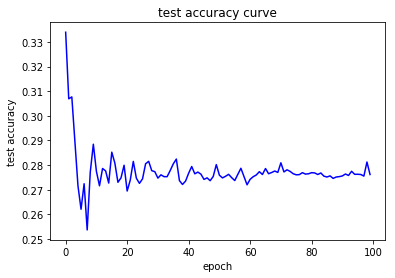

In [13]:
fit(mycnn, num_epochs, optimizer, device)